### 0. Importar librerías

In [1]:
import pandas as pd
import numpy as np

# Se define la semilla aleatoria para que cuando se vuelva a ejecutar el split train-test,
# los datos que contiene cada conjunto sean los mismos.
semilla_aleatoria = 1234

---

# 1. Cargar el dataset

In [2]:
# Ruta del fichero
path = 'datos/datos_filtrados.csv'

# Cargar el dataset
datos = pd.read_csv(path)

# Al ser un dataset pequeño se muestra completo
datos

,AF365,AF450,35 deg,42 deg,Grupo
0,2.320158,1.229614,13.01,19.39,0
1,1.529274,0.616514,8.18,24.78,0
2,1.908257,0.955847,7.75,16.90,0
3,1.590625,1.018495,4.10,16.30,0
4,1.617071,1.242961,5.76,21.05,0
...,...,...,...,...,...
115,3.034884,2.051768,4.55,8.50,2
116,4.093525,3.037288,3.97,5.35,2
117,4.730000,3.040000,7.04,14.44,2
118,3.200000,2.360000,6.70,10.57,2


In [3]:
# Contar el número de instancias de cada grupo
datos['Grupo'].value_counts()

1    61
0    46
2    13
Name: Grupo, dtype: int64

## Preparar conjuntos de entrenamiento y test

In [4]:
# Se separa la variable a predecir (Grupo)
X = datos.drop('Grupo', axis=1)
y = datos['Grupo']

In [5]:
# Importar librería de scikit-learn para separar los datos
from sklearn.model_selection import train_test_split

# Separar datos en conjunto de entrenamiento (80%) y test (20%) de manera estratificada
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=semilla_aleatoria)

In [6]:
# Visualizar la dimensión de los datos separados
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (96, 4)
Training Labels Shape: (96,)
Testing Features Shape: (24, 4)
Testing Labels Shape: (24,)


In [7]:
# Distribución de los grupos en el conjunto de entrenamiento
y_train.value_counts()

1    49
0    37
2    10
Name: Grupo, dtype: int64

In [8]:
# Valores normalizados
y_train.value_counts(normalize=True)

1    0.510417
0    0.385417
2    0.104167
Name: Grupo, dtype: float64

In [9]:
# Distribución de los grupos en el conjunto de test
y_test.value_counts()

1    12
0     9
2     3
Name: Grupo, dtype: int64

In [10]:
# Valores normalizados
y_test.value_counts(normalize=True)

1    0.500
0    0.375
2    0.125
Name: Grupo, dtype: float64

### Visualizar distribución de cada conjunto (entrenamiento y test)

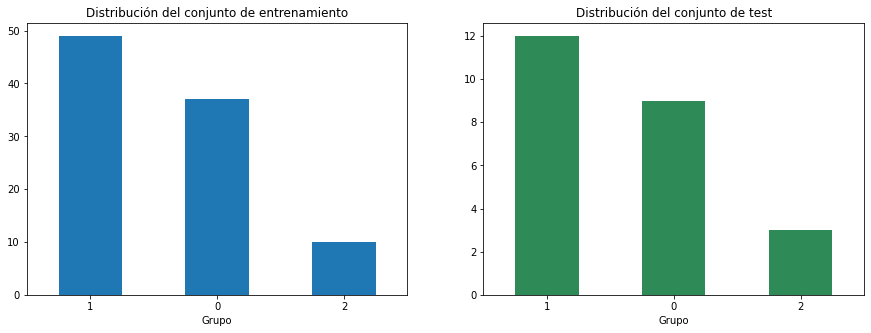

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))

#fig.suptitle("Distribución de los grupos en los conjuntos de entrenamiento y test")

# Representación del conjunto de entrenamiento
plt.subplot(121)
y_train.value_counts().plot(kind='bar')
plt.title('Distribución del conjunto de entrenamiento')
plt.xlabel('Grupo')
plt.xticks(rotation=0)

# Representación del conjunto de test
plt.subplot(122)
y_test.value_counts().plot(kind='bar', color='seagreen')
plt.title('Distribución del conjunto de test')
plt.xlabel('Grupo')
plt.xticks(rotation=0)

plt.show()

---

# 2. Crear el modelo

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

# Definición del modelo
modelo = SVC(random_state=semilla_aleatoria)

# Definición de parámetros de búsqueda
parametros = [
    {'C': [0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
    ]

# Definición de los folds estratificados
folds = StratifiedKFold(n_splits=8, shuffle=True, random_state=semilla_aleatoria)

# Búsqueda de parámetros
grid = GridSearchCV(
    estimator  = modelo,
    param_grid = parametros,
    scoring    = 'accuracy',
    cv         = folds,
    verbose    = 0,
    return_train_score = True
    )

# Entrenamiento
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=1234, shuffle=True),
             estimator=SVC(random_state=1234),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
             return_train_score=True, scoring='accuracy')

In [13]:
# Visualización de los resultados de la búsqueda
df_resultados = pd.DataFrame(grid.cv_results_)
df_resultados = df_resultados.sort_values(by=['rank_test_score'])
df_resultados = df_resultados.set_index(
    df_resultados["params"].apply(lambda x: '_'.join(str(val) for val in x.values()))
).rename_axis("kernel")
df_resultados[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']].head()

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1_linear,"{'C': 1, 'kernel': 'linear'}",1,0.802083,0.131349
1000_0.0001_rbf,"{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}",2,0.791667,0.110240
100_0.001_rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",2,0.791667,0.110240
0.1_linear,"{'C': 0.1, 'kernel': 'linear'}",4,0.781250,0.109746
1000_0.001_rbf,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",4,0.781250,0.131349


In [14]:
# Se muestran los mejores parámetros
print('Mejores parámetros: ', grid.best_params_)

Mejores parámetros:  {'C': 1, 'kernel': 'linear'}


In [15]:
# Se crea el modelo con los parámetros obtenidos
modelo_svc = SVC(C=1, kernel='linear')

# Se entrena el modelo
modelo_svc.fit(X_train, y_train)

SVC(C=1, kernel='linear')

---

# 3. Evaluar el modelo

In [16]:
# Se lleva a cabo la predicción para evaluar el modelo
y_pred = modelo_svc.predict(X_test)

In [17]:
# Visualización de las predicciones
print(y_pred)

[1 1 0 0 1 0 1 2 1 1 1 0 0 1 0 1 0 0 2 0 0 1 1 1]


## Matriz de confusión

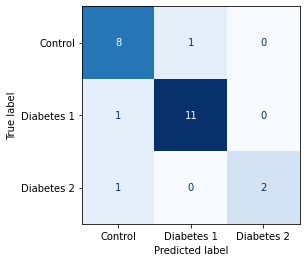

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, y_pred)
# Filas: valores reales
# Columnas: predicción

clases = ['Control', 'Diabetes 1', 'Diabetes 2']

# Visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)

disp.plot(cmap='Blues', colorbar=False)
plt.show()

## Classification report

In [19]:
clases = ['Control', 'Diabetes 1', 'Diabetes 2']

print(classification_report(y_test, y_pred, target_names=clases, digits=4))

              precision    recall  f1-score   support

     Control     0.8000    0.8889    0.8421         9
  Diabetes 1     0.9167    0.9167    0.9167        12
  Diabetes 2     1.0000    0.6667    0.8000         3

    accuracy                         0.8750        24
   macro avg     0.9056    0.8241    0.8529        24
weighted avg     0.8833    0.8750    0.8741        24

